# Neural Networks using Keras

## Preparing the Keras framework

Our goal is to tune the Apple Store NN for multi-class classification. We need to make several decisions when configuring our NN and focus on finding the optimal parameters for the
 - number of hidden layers
 - number of neurons in hidden layers
 - activation functions
 - type of weight initialization
 - learning rate and momentum
 - optimizer
 - size of batch
 - number of epochs
 - regularization (dropout)



In a first Part of this Notebook we will use Grid Search for Hyperparameter Tuning.

Then in a second Part we will use Keras-Tuner

In [1]:
# Setting up the environment: import standard libraries and load the data. 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#This package provides utilities for Keras, such as modified callbacks, data genereators, encoder, etc.
#from keras.utils import np_utils    # it does not work now
from tensorflow.keras import utils   # this works



##Use case: app rating analysis
NNs often **solve classification problems with many classes**. To illustrate their functioning in a context that is more related to NLP examples,we introduce the data set concerned with app ratings. The **original data is available on Kaggle**. There, you also find a data dictionary with some information on the variables. However, the variable names are rather self-explanatory. A cleaned version of the data is available in this folder. The easiest way for you is to use the cleaned version but feel very free to play around with the version on Kaggle. You can find a Python script that starts from the original data and goes through a couple of pre-processing operations to produce the version we use below (**app_store_dpp.py**).

In [ ]:
# Load dataset and set app name as index

app = pd.read_csv("https://raw.githubusercontent.com/murpi/wilddata/master/quests/AppleStore_prep.csv", 
                  index_col=False, sep='\t', encoding='utf-8')
app = app.set_index('track_name')
app.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7197 entries, PAC-MAN Premium to Escape the Sweet Shop Series
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   size_bytes                     7197 non-null   float64
 1   price                          7197 non-null   float64
 2   rating_count_tot               7197 non-null   float64
 3   sup_devices.num                7197 non-null   float64
 4   ipadSc_urls.num                7197 non-null   float64
 5   lang.num                       7197 non-null   float64
 6   vpp_lic                        7197 non-null   float64
 7   currency_USD                   7197 non-null   int64  
 8   cont_rating_12+                7197 non-null   int64  
 9   cont_rating_17+                7197 non-null   int64  
 10  cont_rating_4+                 7197 non-null   int64  
 11  cont_rating_9+                 7197 non-null   int64  
 12  prime_genre_Boo

So **36 columns**, **one of which is the target variable**. We consider the **user rating as our target** and will try to set up a NN that predict the rating from the app characteristics including information on its price, genre, etc.

Let's have a quick look at the target variable. Note that we that we have reduced the number of rating classes compared to the original version of the data on Kaggle (see app_store_dpp.py for details).  


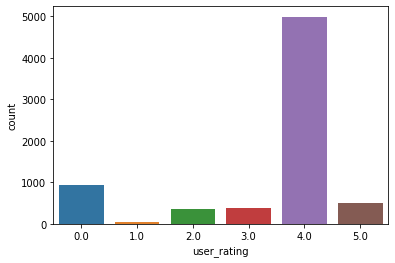

In [ ]:
# Inspect the target
import seaborn as sns
sns.countplot(x=app.user_rating);

In [ ]:
app["user_rating"]

track_name
PAC-MAN Premium                                       4.0
Evernote - stay organized                             4.0
WeatherBug - Local Weather, Radar, Maps, Alerts       4.0
eBay: Best App to Buy, Sell, Save! Online Shopping    4.0
Bible                                                 4.0
                                                     ... 
Kubik                                                 4.0
VR Roller-Coaster                                     4.0
Bret Michaels Emojis + Lyric Keyboard                 4.0
VR Roller Coaster World - Virtual Reality             4.0
Escape the Sweet Shop Series                          5.0
Name: user_rating, Length: 7197, dtype: float64

In [ ]:
# Prepare the target variable
# LabelEncoder() transforms a string vector to a num vector
encoder = LabelEncoder()
#fit label encoder
encoder.fit(app["user_rating"])
#transform and return encoded labels
encoder.transform(app["user_rating"])

#in this case it is not necessary, the labels are already numeric in appropriate range of 0...5


array([4, 4, 4, ..., 4, 4, 5])

In [ ]:
#dummy_y = np_utils.to_categorical( encoder.transform(app["user_rating"])).astype(int)
#dummy_y

In [ ]:
# do the one_hot_encoding directly with the target data
dummy_y = utils.to_categorical((app["user_rating"])).astype(int)
dummy_y

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]])

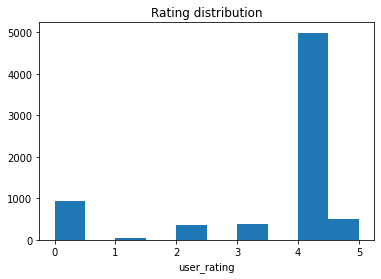

(5037, 35)
(5037, 6)


In [ ]:
plt.hist(dummy_y.argmax(axis=1))
plt.xlabel('user_rating')
plt.title('Rating distribution')
plt.show();

# Let's split our data set

#Seed function is used to save the state of a random function, so that it can generate same random numbers on multiple executions of the code on the same machine or on different machines (for a specific seed value)
seed=42

X = app.iloc[:,:-1].values
y = dummy_y

# Keep in mind that this data set is already standardized, which leads to a leakage of information from train set to test set
# When you are working with a dataset, make sure you standardize the variables in test set according to the parameters of the train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=seed)
    
print (X_train.shape)
print(y_train.shape) 
#X.head(5)

## Preparing the Keras framework


Today we will revise the architecture of our basic neural network and look more into the tuning of hyperparameters.



In [ ]:
nb_units = 128
# And finally the outout layer
nb_classes = y.shape[1]

In [ ]:
# Import Keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adamax


model = Sequential()
model.add(Dense(nb_units, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed), input_shape=(X.shape[1],)))
#model.add(Dropout(0.1))
model.add(Dense(nb_units, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed)))
#model.add(Dropout(0.1))
model.add(Dense(nb_classes, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               4608      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 21,894
Trainable params: 21,894
Non-trainable params: 0
_________________________________________________________________


In [ ]:

batch_size = 56 #1 for online SGD

# example: start trining the model up until 30 epochs and plot the training loss values and validation loss values against number of epochs.
epochs = 30


model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01), metrics=['accuracy'])
# Fit the model
story = model.fit(X_train, y_train, #name model differently
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(X_test, y_test))
                    #validation_split=0.33)#validation_data=(X_test, y_test)


In [ ]:
def show_history(story):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18.5, 10.5)
    ax1.plot(story.history['accuracy'])
    ax1.plot(story.history['val_accuracy'])
    ax1.set(xlabel='epoch', ylabel='accuracy')
    ax1.legend(['train_accuracy', 'test_accuracy'], loc='best')
    ax1.set_title('Accuracy evolution during NN training')
    
    ax2.plot(story.history['loss'])
    ax2.plot(story.history['val_loss'])
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train_loss', 'test_loss'], loc='best')
    ax2.set_title('Loss evolution during NN training')
    plt.show()


In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)

Test loss: 0.9501454830169678
Test accuracy: 0.706944465637207


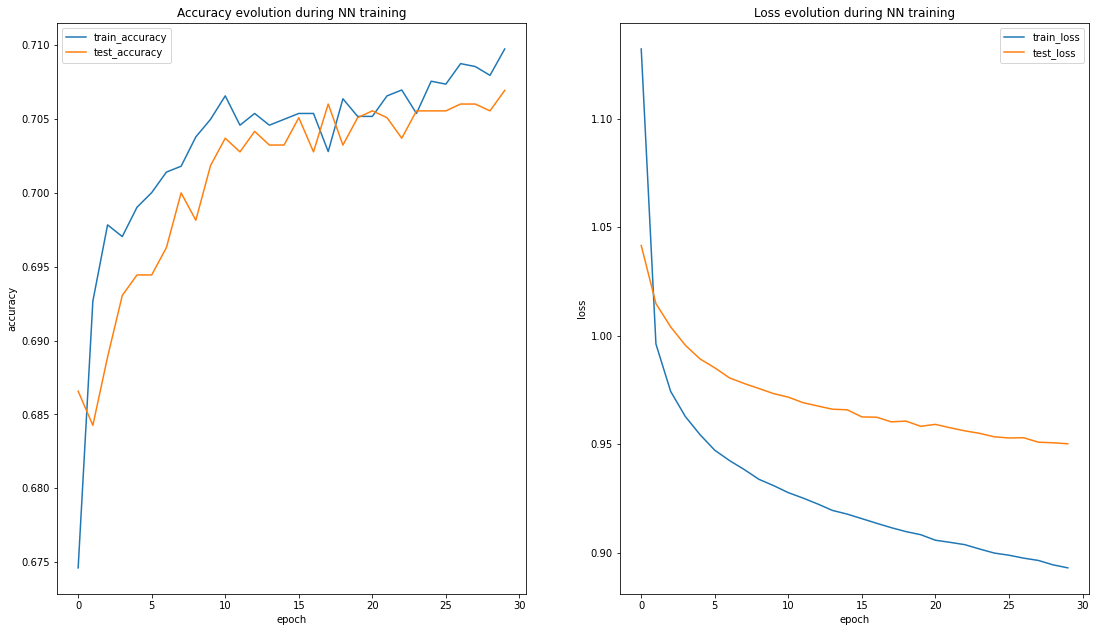

In [ ]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])
show_history(story)

# Part 1: Hyperparameter optimization with Keras

We will start with the old-fashioned way with Scikit Learn and will first show you an example of how to use GridSearch with two groups of hyperparameters: batches/epochs and optimizer algorithms. 

In [ ]:
#import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import optimizers

In [ ]:
#We will use the architecture we had before and wrap it into the function called 'network ' (or whatever you want to call it)

def network():
    
    model = Sequential()
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed),  input_shape=(X.shape[1],)))
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed)))
    model.add(Dense(6, activation='softmax',kernel_initializer=keras.initializers.he_normal(seed=seed)))
    
    model.compile(optimizer=optimizers.SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy']) #nothing changes here

    return model

# Now we will plug it into Keras Classifier Wrapper 
model = KerasClassifier(build_fn=network, verbose=0)

In [ ]:
# Let's define the grid search parameters
batchsize = [32, 64, 128, 256, 512]
epochs = [10,30,60,70]

In [ ]:
#Set the grid
param_grid = dict(batch_size=batchsize, epochs=epochs)# setting a dictionary to store the results
param_grid 

{'batch_size': [32, 64, 128, 256, 512], 'epochs': [10, 30, 60, 70]}

In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1,cv=3) #parallelization, here using all processors
results = grid.fit(X_train, y_train) #remember that we don't want to use the test set in CV
print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.711535 using {'batch_size': 32, 'epochs': 70}


In [ ]:
#Let's now take this knowledge and apply it to our optimizers tuning

def optim_opt (optimizer='SGD'):
    model = Sequential()
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed),  input_shape=(X.shape[1],)))
  
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed)))
 
    model.add(Dense(6, activation='softmax',kernel_initializer=keras.initializers.he_normal(seed=seed)))
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 
    
    return model

#model = KerasClassifier(build_fn=optim, epochs=30, batch_size=64, verbose=0)
model = KerasClassifier(build_fn=optim_opt, epochs=60, batch_size=32, verbose=0)
# define the grid search parameters
optimizers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizers) # setting a dictionary to store the results
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid.fit(X_train, y_train)

# Our results (remember these are the results on the hold-out data)
print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.705380 using {'optimizer': 'Adamax'}


Now continue using Grid Search to tune the Learning Rate and Momentum:

In [ ]:
def optim_opt (learning_rate=0.01, momentum=0):
    model = Sequential()
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed),  input_shape=(X.shape[1],)))
  
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed)))
 
    model.add(Dense(6, activation='softmax',kernel_initializer=keras.initializers.he_normal(seed=seed)))
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 
    
    return model

model = KerasClassifier(build_fn=optim_opt, epochs=60, batch_size=32, verbose=0)
# define the grid search parameters
learning_rate = [0.1, 0.01, 0.001, 0.0001]
momentum = [0.0, 0.1, 0.2, 0.4, 0.8]
param_grid = dict(learning_rate=learning_rate, momentum=momentum) # setting a dictionary to store the results
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid.fit(X_train, y_train)

# Our results (remember these are the results on the hold-out data)
print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.711932 using {'learning_rate': 0.01, 'momentum': 0.4}


Use Grid Search to tune the Network Weight Initialization:

In [ ]:
def optim_init (init_mode='zero'):
    model = Sequential()
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=init_mode,  input_shape=(X.shape[1],)))
  
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=init_mode))
 
    model.add(Dense(6, activation='softmax',kernel_initializer=init_mode,))
    optimizer = SGD(learning_rate=0.01, momentum=0.4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 
    
    return model

model = KerasClassifier(build_fn=optim_init, epochs=60, batch_size=32, verbose=0)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid.fit(X_train, y_train)

# Our results (remember these are the results on the hold-out data)
print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.711336 using {'init_mode': 'normal'}


Use Grid Search to tune the Neuron Activation Function


In [ ]:
def optim_act (activation='relu'):
    model = Sequential()
    model.add(Dense(128, activation=activation, bias_initializer='zeros',kernel_initializer='normal',  input_shape=(X.shape[1],)))
  
    model.add(Dense(128, activation=activation,bias_initializer='zeros',kernel_initializer='normal'))
 
    model.add(Dense(6, activation='softmax',kernel_initializer='normal',))
    optimizer = SGD(learning_rate=0.01, momentum=0.4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 
    
    return model

model = KerasClassifier(build_fn=optim_act, epochs=60, batch_size=32, verbose=0)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid.fit(X_train, y_train)

# Our results (remember these are the results on the hold-out data)
print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.711336 using {'activation': 'relu'}


Use Grid Search to tune Dropout Regularization

In [ ]:
def optim_drop (dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(128, activation='relu', bias_initializer='zeros',kernel_initializer='normal',  input_shape=(X.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer='normal'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(6, activation='softmax',kernel_initializer='normal',))
    optimizer = SGD(learning_rate=0.01, momentum=0.4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 
    
    return model

model = KerasClassifier(build_fn=optim_drop, epochs=60, batch_size=32, verbose=0)
# define the grid search parameters
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid.fit(X_train, y_train)

# Our results (remember these are the results on the hold-out data)
print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.709748 using {'dropout_rate': 0.1}


Use Grid Search to tune the Number of Neurons in the Hidden Layer

In [ ]:
def optim_nodes(nodes=128):
    model = Sequential()
    model.add(Dense(nodes, activation='relu', bias_initializer='zeros',kernel_initializer='normal',  input_shape=(X.shape[1],)))
    model.add(Dropout(0.1))
    model.add(Dense(nodes, activation='relu',bias_initializer='zeros',kernel_initializer='normal'))
    model.add(Dropout(0.1))
    model.add(Dense(6, activation='softmax',kernel_initializer='normal',))
    optimizer = SGD(learning_rate=0.01, momentum=0.4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 
    
    return model

model = KerasClassifier(build_fn=optim_nodes, epochs=60, batch_size=32, verbose=0)
# define the grid search parameters
nodes = [16, 32, 35, 64,128,256]
param_grid = dict(nodes=nodes)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid.fit(X_train, y_train)

# Our results (remember these are the results on the hold-out data)
print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.710939 using {'nodes': 128}


# Part 2: Keras Tuner

In [ ]:
pip install -U keras-tuner


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

import tensorflow as tf
import kerastuner as kt
print(tf.__version__)
print(kt.__version__)

2.4.1
1.0.3


Read through the Keras Tuner Documentation and build a RandomSearch. This hyperparameter tuning method randomly tries a combination of hyperparameters from a given search space. To use this method in keras tuner, first define a tuner using one of the available [Tuners](https://keras-team.github.io/keras-tuner/documentation/tuners/).


In [ ]:
help(RandomSearch)   # it prints the docstring

In [ ]:
def build_model(hp, input_shape=(X.shape[1],)):
    model = keras.Sequential()
    #hp.int specifies its an integer number, you say min, max and a step size, first value it will check is 32, then 160 etc.
    # you can vary activation function as well
    
    # add the first layer just for getting the input:
    model.add(layers.InputLayer(input_shape=input_shape))
    
    # add multiple hidden layers - you do not need specify the 'input_shape' !!!  
    for i in range(hp.Int('layers',min_value=1, max_value=3, step=1)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=256,
                                            step=64),
                            activation=hp.Choice('activation_' + str(i),['relu', 'tanh', 'sigmoid', 'linear']),)),
        # Alternatively instead of using hp.Int, you could use hp.Choice:
        # model.add(layers.Dense(units=hp.Choice('units',[32,160]),
        #                      activation='relu'))
 
    # output layer
    model.add(layers.Dense(6, activation='softmax'))

    
    model.compile(
        optimizer=keras.optimizers.Adamax(
            hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])),
            # or hp.Float() for learning rate or dropout
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
tuner = RandomSearch(
    #provide it the build_model function
    build_model,
    #The objective is the function to optimize. 
    #The tuner infers if it is a maximization or a minimization problem based on its value.
    objective='val_accuracy',
    #max_trials represents the number of hyperparameter combinations that will be tested by the tuner, 
    #max number of trials = model config to test at most
    #while execution_per_trial is the number of models that should be built and fit for each trial for robustness purposes.
    max_trials=10,
    # in each trial will do 3 different models
    # the number of models that should be built and fit for each trial
    # the higher number of trials the better, but depends on your time and resources
    executions_per_trial=3,
    seed=42,
    directory='/work/my_dir',
    project_name='tuner_proj')

In [ ]:
# tells you how many hyperparameters you are looking for ,
# 2 for hidden unit params and learning rate
tuner.search_space_summary()

Search space summary
Default search space size: 4
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 64, 'sampling': None}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid', 'linear'], 'ordered': False}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
# now we fit data, tuner.search is aq to model.fit
#Here's what happens in search: models are built iteratively by calling the model-building function, 
#which populates the hyperparameter space (search space) tracked by the hp object.
# The tuner progressively explores the space, recording metrics for each configuration.
tuner.search(X_train, y_train,
             epochs=5,
             validation_data=(X_test,y_test))
             #callback = cb)

Trial 10 Complete [00h 00m 13s]
val_accuracy: 0.7054012219111124

Best val_accuracy So Far: 0.712808628877004
Total elapsed time: 00h 02m 12s
INFO:tensorflow:Oracle triggered exit


In [ ]:
#shows hyperparameters and accuracy
tuner.results_summary()

Results summary
Results in /work/my_dir/tuner_proj
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
layers: 2
units_0: 96
activation_0: relu
learning_rate: 0.01
units_1: 96
activation_1: relu
units_2: 96
activation_2: relu
Score: 0.712808628877004
Trial summary
Hyperparameters:
layers: 2
units_0: 224
activation_0: tanh
learning_rate: 0.01
units_1: 96
activation_1: tanh
units_2: 96
activation_2: linear
Score: 0.712808628877004
Trial summary
Hyperparameters:
layers: 2
units_0: 224
activation_0: tanh
learning_rate: 0.01
units_1: 96
activation_1: linear
units_2: 96
activation_2: linear
Score: 0.707253078619639
Trial summary
Hyperparameters:
layers: 1
units_0: 96
activation_0: linear
learning_rate: 0.01
units_1: 160
activation_1: relu
units_2: 96
activation_2: sigmoid
Score: 0.7054012219111124
Trial summary
Hyperparameters:
layers: 2
units_0: 160
activation_0: relu
learning_rate: 0.001
units_1: 32
activation_1: sigmoid
units_2: 224
activa

In [ ]:
n_best_models = tuner.get_best_models(num_models=3)       # gets the 3 best models
best_hp_params = tuner.get_best_hyperparameters(1)[0]     # gets the hyperparameters for the best model


In [ ]:
n_best_models[0]._has_explicit_input_shape   # this is True only if the build function defines the input shape

True

In [ ]:
n_best_models[0].summary()     # structure of the best model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 96)                3456      
_________________________________________________________________
dense_1 (Dense)              (None, 96)                9312      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 582       
Total params: 13,350
Trainable params: 13,350
Non-trainable params: 0
_________________________________________________________________


In [ ]:
best_hp_params.values      # hyperparameters of the best model

{'layers': 2,
 'units_0': 96,
 'activation_0': 'relu',
 'learning_rate': 0.01,
 'units_1': 96,
 'activation_1': 'relu',
 'units_2': 96,
 'activation_2': 'relu'}

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a109ea11-a7da-42aa-8af0-3a0cdafc917e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>